In [1]:
from ftpr.visualization import PhaseVisualizer
import pandas as pd
from tslearn.barycenters import dtw_barycenter_averaging
from mplsoccer import Pitch
import numpy as np
import pickle
from ftpr.clustering import PhaseClustering
from ftpr.dataloader import load_phases, load_phase
from collections import Counter
from tslearn.metrics import dtw_path

In [2]:
team = 'Manchester City'
df = pd.read_csv(f'../data/team_phases/{team}.csv')

/var/folders/tv/_qfcls8d76jd1sp6y_8qsd700000gn/T/ipykernel_31763/355048859.py:2: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'../data/team_phases/{team}.csv')


In [3]:
df

,Unnamed: 0,carry_end_location,dribble_outcome,id,index,location,match_id,out,pass_angle,pass_assisted_shot_id,...,shot_statsbomb_xg,shot_type,tactics,team,team_id,timestamp,type,foul_won_penalty,pass_goal_assist,phase_id
0,14,NaN,NaN,f5a217d2-0ba0-49bb-9854-0c26fe2060ae,28,"[47.6, 44.4]",3754045,NaN,2.139644,NaN,...,NaN,NaN,NaN,Manchester City,36,00:00:17.793,Pass,NaN,NaN,0
1,919,NaN,NaN,60ad5e93-2411-4cb0-a750-988d0067ecfd,29,"[43.7, 50.5]",3754045,NaN,NaN,NaN,...,NaN,NaN,NaN,Manchester City,36,00:00:18.826,Ball Receipt*,NaN,NaN,0
2,15,NaN,NaN,c13b671d-4bfa-4a85-8ba3-a7253ab0cc5a,30,"[43.7, 50.5]",3754045,NaN,0.268366,NaN,...,NaN,NaN,NaN,Manchester City,36,00:00:18.828,Pass,NaN,NaN,0
3,920,NaN,NaN,94b03a78-6f28-4fc4-85ea-fb346e86dbf1,32,"[67.7, 54.9]",3754045,NaN,NaN,NaN,...,NaN,NaN,NaN,Manchester City,36,00:00:21.201,Ball Receipt*,NaN,NaN,0
4,2909,NaN,NaN,85cbd8ed-5355-4684-a2f3-90741b2c2504,34,"[50.1, 59.6]",3754045,NaN,NaN,NaN,...,NaN,NaN,NaN,Manchester City,36,00:00:22.792,Ball Recovery,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67442,2914,"[67.4, 53.0]",NaN,80741271-02df-4528-871c-1276f325338b,3657,"[55.7, 46.0]",3754258,NaN,NaN,NaN,...,NaN,NaN,NaN,Manchester City,36,00:48:51.696,Carry,NaN,NaN,8023
67443,1074,NaN,NaN,3affe8ca-7aae-429c-b127-debf7deceb45,3659,"[67.4, 53.0]",3754258,NaN,0.706969,NaN,...,NaN,NaN,NaN,Manchester City,36,00:48:54.822,Pass,NaN,NaN,8023
67444,2092,NaN,NaN,e7fe2357-96a7-4252-868a-95be1c6cc237,3660,"[87.3, 70.0]",3754258,NaN,NaN,NaN,...,NaN,NaN,NaN,Manchester City,36,00:48:55.816,Ball Receipt*,NaN,NaN,8023
67445,2915,"[92.6, 67.0]",NaN,232831dd-58ad-420d-b313-8b9e076c77b2,3661,"[87.3, 70.0]",3754258,NaN,NaN,NaN,...,NaN,NaN,NaN,Manchester City,36,00:48:55.816,Carry,NaN,NaN,8023


In [4]:
phases = load_phases(df, filter_static_events=True, min_phase_length=3, n_jobs=8)

AttributeError: Can't pickle local object 'load_phases.<locals>.worker'

In [5]:
phases[0].get_summary()

,location,pass_end_location,carry_end_location,type,timestamp
4,"[50.1, 59.6]",NaN,NaN,Ball Recovery,00:00:22.792
5,"[50.1, 59.6]",NaN,"[51.2, 59.3]",Carry,00:00:22.792
6,"[51.2, 59.3]","[51.2, 59.3]",NaN,Pass,00:00:23.923


In [6]:
len(phases)

4477

In [7]:
shot_dist = dict()
for phase in phases:
    count = Counter(phase['type']).get('Shot', 0)
    shot_dist[count] = shot_dist.get(count, 0) + 1

shot_dist

{0: 3958, 1: 518, 2: 1}

In [8]:
clustering = PhaseClustering(phases)

In [10]:
n_clusters = 100
cls_pred = clustering.agglomerative_fit(n_clusters=n_clusters, metric='dtw', linkage='complete')
cls_pred

array([52, 68, 52, ..., 38, 13, 78])

In [11]:
cluster_score = [0 for _ in range(n_clusters)]
cluster_dist = []
for cluster_id in range(n_clusters):
    phases_in_cluster = clustering.get_cluster_phases(cluster_id)
    cluster_dist.append(len(phases_in_cluster))
    for phase in phases_in_cluster:
        cluster_score[cluster_id] += Counter(phase['type']).get('Shot', 0)
np.array(cluster_score)

array([ 1,  8, 67, 13,  0,  1, 14,  0,  3,  0,  3,  4,  4, 21,  0,  3,  0,
        1,  0,  0,  1,  1,  2,  0,  0, 13, 11,  2,  1,  0,  8,  1, 11,  1,
        2,  4,  1,  2,  3,  1,  0,  0,  2,  1,  0,  1,  0,  0,  0,  0,  9,
       83,  0, 28,  2,  0,  0,  0,  0,  0,  5,  0,  1,  1,  0,  1,  0,  0,
        0, 26,  1, 78,  0,  2,  3,  2,  2,  9,  1,  0,  0,  0,  0,  4,  0,
        1,  0,  5,  1,  0,  0,  2,  5,  0,  0, 31,  5,  0,  0,  0])

In [12]:
np.array(cluster_dist)

array([105, 105, 181, 198,   9,   6,  77, 120,  19,  13,  14,  26,  58,
        44,  20,  13,   6,  11,   4,   4,   9,  21, 126,   5,   4,  44,
        30,  10,  39,  31,  16,  10,  54,  10,  51,  26,  18,  10,  65,
         6,  35,  35, 105,   8,   8, 111,   7,   7,   2,  51,  30, 227,
       225, 117, 214,   3,  15,   1,   2,   2,  19,   8,  27,  12,   3,
        45,   7,  16,  11, 107,   7, 174, 313,   7,  24,   3,   7,  44,
       205,  12, 131,  49,   2,  15,   6,   4,  19,   6,   1,   1,   6,
        17,  19,   7,  16, 171, 124,   5,   1,   3])

In [13]:
best_clusters = np.argsort(cluster_score)[::-1]
best_clusters

array([51, 71,  2, 95, 53, 69, 13,  6,  3, 25, 32, 26, 50, 77, 30,  1, 87,
       60, 96, 92, 11, 12, 83, 35, 10, 38, 74,  8, 15, 42, 91, 27, 22, 34,
       37, 73, 75, 76, 54, 43, 28, 45, 33, 39, 36,  0, 21, 63,  5, 88, 85,
       78, 70, 31, 65, 62, 17, 20, 16, 23, 29, 18,  9,  7, 24, 19,  4, 14,
       99, 40, 67, 97, 94, 93, 90, 89, 86, 84, 82, 81, 80, 79, 72, 68, 66,
       41, 64, 61, 59, 58, 57, 56, 55, 52, 98, 48, 47, 46, 44, 49])

In [14]:
ith_best = 0
series_in_cluster = clustering.get_cluster_series(best_clusters[ith_best])
len(series_in_cluster)

227

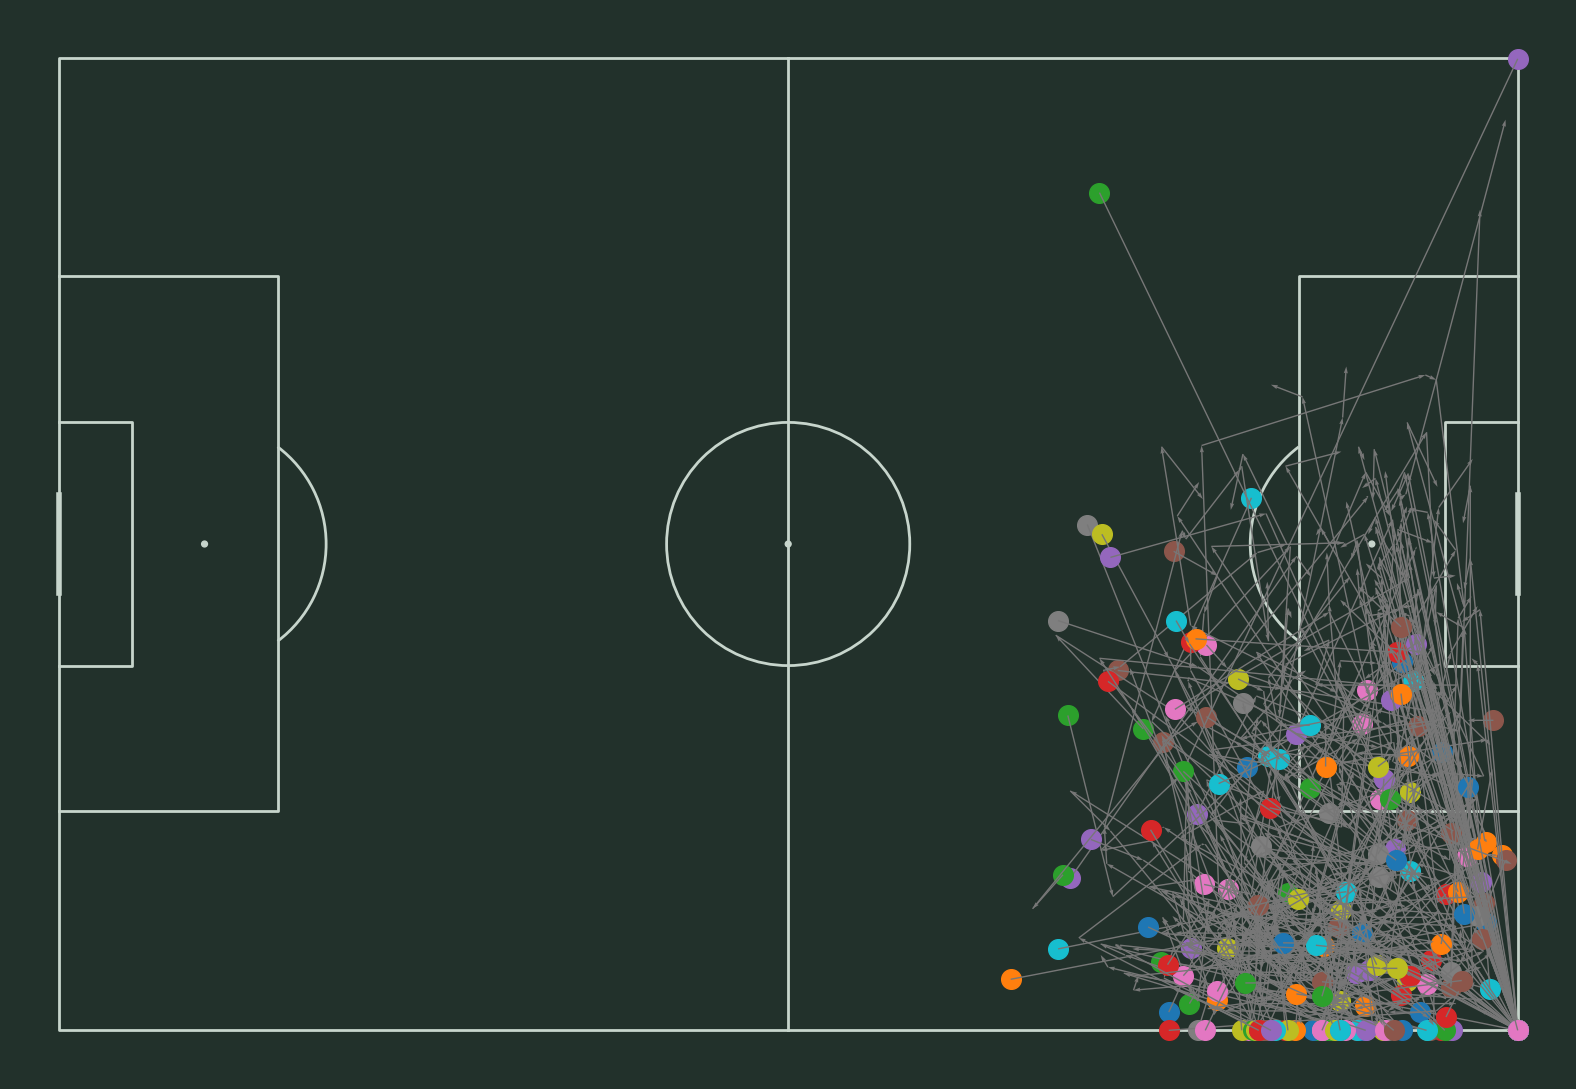

In [15]:
pitch = Pitch(pitch_type='statsbomb', pitch_color='#22312b', line_color='#c7d5cc')
fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=False, tight_layout=True)
fig.set_facecolor('#22312b')

pv = PhaseVisualizer((16, 10))

for ser in series_in_cluster:
    pitch.scatter(ser[0, 0], ser[0, 1], s=200, ax=ax)
    for i in range(len(ser) - 1):
        pitch.arrows(ser[i, 0], ser[i, 1], ser[i + 1, 0], ser[i + 1, 1],
                        color='#777777', ax=ax, width=1)


In [72]:
bary = dtw_barycenter_averaging(series_in_cluster)

In [73]:
bary

array([[107.66801619,  71.10040486],
       [104.15535714,  69.41071429],
       [109.20396476,  70.98061674],
       [109.35859031,  71.0784141 ],
       [109.39207048,  71.01806167],
       [109.39207048,  71.01806167],
       [109.39207048,  71.01806167],
       [109.39207048,  71.01806167],
       [109.39207048,  71.01806167],
       [109.30176211,  71.06651982],
       [108.62183406,  70.95065502],
       [106.3545082 ,  62.37090164],
       [106.73343849,  53.87287066]])

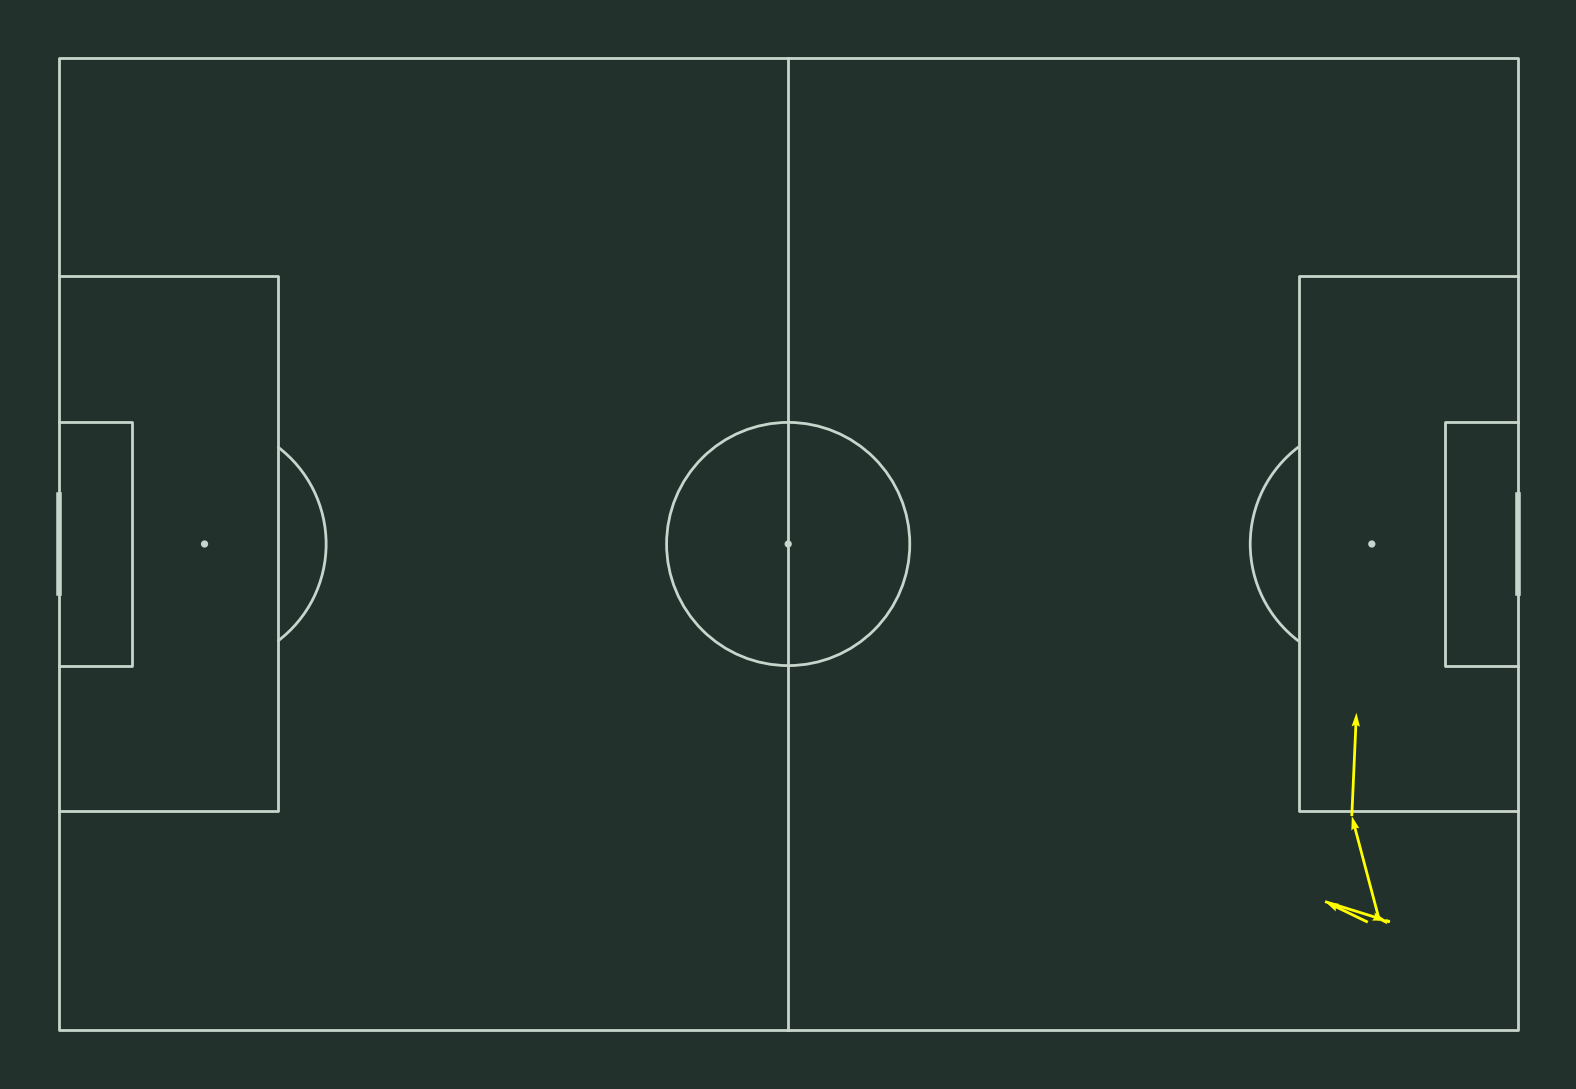

In [74]:
pitch = Pitch(pitch_type='statsbomb', pitch_color='#22312b', line_color='#c7d5cc')
fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=False, tight_layout=True)
fig.set_facecolor('#22312b')

pv = PhaseVisualizer((16, 10))

for i in range(len(bary) - 1):
    pitch.arrows(bary[i, 0], bary[i, 1], bary[i + 1, 0], bary[i + 1, 1],
                    color='#ffff00', ax=ax, width=2)